In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np

simple_agent = \
         [[ 1,  0,  0,  0,  0,  2, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  3,  0,  0, 0]]
simple_world = \
         [[  0,  0,  0,  0,  0,  0, 0],
          [  0,  0,  0,  1,  0,  0, 0],
          [  1,  0,  0,  0,  1,  0, 0],
          [  0,  0,  0,  1,  0,  0, 0],
          [  0,  0,  0,  0,  0,  0, 0],
          [  0,  0,  0,  0,  0,  0, 0]]
env = WarehouseEnv(agent_map=np.array(simple_agent), obstacle_map=np.array(simple_world))

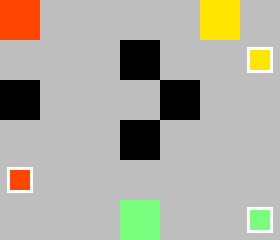

In [3]:
env.render(zoom_size=40)

[None, None, None, None]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]


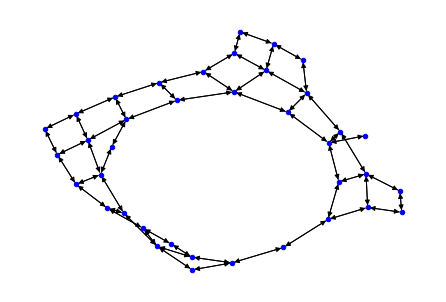

In [4]:
import networkx as nx

def warehouse_to_graph(env):
    w, h = env.agent_map.shape[0], env.agent_map.shape[1]
    G = nx.grid_2d_graph(w, h)
    H = G.to_directed()

    obstacles = np.argwhere(env.obstacle_map > 0)
    
    print([H.remove_node((o[0], o[1])) for o in obstacles])
    return H

env_graph = warehouse_to_graph(env)
pos = nx.spring_layout(env_graph, iterations=1)
nx.draw(env_graph, node_color="b", node_size=20, with_labels=False)
print(env_graph.nodes)

In [14]:
from od_mstar3 import cpp_mstar

def get_next_action(env, env_graph, coordinated_planner=False):
    if not coordinated_planner:
        location = env.agent_state[env.current_agent_id]
        goal = env.agent_goal[env.current_agent_id]

        path = nx.astar_path(env_graph, (location[0], location[1]), (goal[0], goal[1]))

        action = None
        start_x, start_y = path[0]
        next_x, next_y = path[1]
    else:
        states = [(v[0], v[1]) for k, v in env.agent_state.items()]
        goals = [(v[0], v[1]) for k, v in env.agent_goal.items()]
        path = cpp_mstar.find_path(env.obstacle_map, states, goals, 10, 5 * 60.0)

        start_x, start_y = env.agent_state[env.current_agent_id]
        next_x, next_y = path[1][env.current_agent_id]
        
    if (start_y + 1)  == next_y:
        return_val = 0
    elif (start_y - 1) == next_y:
        return_val = 2
    elif (start_x - 1) == next_x:
        return_val = 1
    elif (start_x + 1) == next_x:
        return_val = 3
    else:
        return_val = 4
    
    return return_val

In [21]:
#Run the env
observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(zoom_size=40, agent_id=None))
    action = get_next_action(env, env_graph, coordinated_planner=True)
    env.step(action)

frames[0].save('gym_animation_mstar.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=125, loop=0)

In [22]:
#Run the env
observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(zoom_size=40, agent_id=None))
    action = get_next_action(env, env_graph, coordinated_planner=False)
    env.step(action)

frames[0].save('gym_animation_astar.gif',
               save_all= True, append_images=frames[1:], 
               optimize=False, duration=125, loop=0)

In [17]:
from stable_baselines import A2C

model_file = "/Users/pehuen/Documents/ucla/classes/compRob/Relational_DRL/exp_result/WarehouseEnv_A2C_RelationalPolicy/log_2"
a2c_model = A2C.load(model_file + "/model.pkl")

Loading a model without an environment, this model cannot be trained until it has a valid environment.
self.processed_obs Tensor("input/truediv:0", shape=(?, 6, 7, 5), dtype=float32)
entities: Tensor("model/Reshape:0", shape=(?, 12, 64), dtype=float32)
layerNorm_mean (?, 12, 1)
MHDPA_output Tensor("model/MatMul_1:0", shape=(?, 2, 12, 64), dtype=float32)
residual_output Tensor("model/residualNet/Add:0", shape=(?, 2, 12, 64), dtype=float32)
maxpooling_output Tensor("model/Max:0", shape=(?, 2, 64), dtype=float32)
self.processed_obs Tensor("train_model/input/truediv:0", shape=(?, 6, 7, 5), dtype=float32)
entities: Tensor("train_model/model/Reshape:0", shape=(?, 12, 64), dtype=float32)
layerNorm_mean (?, 12, 1)
MHDPA_output Tensor("train_model/model/MatMul_1:0", shape=(?, 2, 12, 64), dtype=float32)
residual_output Tensor("train_model/model/residualNet/Add:0", shape=(?, 2, 12, 64), dtype=float32)
maxpooling_output Tensor("train_model/model/Max:0", shape=(?, 2, 64), dtype=float32)


In [120]:
#Run the env
observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(zoom_size=40, agent_id=None))
    action = get_next_action(env, env_graph, coordinated_planner=False)
    env.step(action)

frames[0].save('gym_animation.gif',
               save_all= True, append_images=frames[1:], 
               optimize=False, duration=125, loop=0)

({'gamma': 0.99,
  'n_steps': 50,
  'vf_coef': 0.25,
  'ent_coef': 0.01,
  'max_grad_norm': 0.5,
  'learning_rate': 0.0007,
  'alpha': 0.99,
  'epsilon': 1e-05,
  'lr_schedule': 'constant',
  'verbose': 1,
  'policy': relational_policies.RelationalPolicy,
  'observation_space': Box(6, 7, 5),
  'action_space': Discrete(5),
  'n_envs': 4,
  'n_cpu_tf_sess': None,
  'seed': None,
  '_vectorize_action': False,
  'policy_kwargs': {}},
 OrderedDict([('model/c1/w:0',
               array([[[[-0.28677654,  0.18066153, -0.01233187, ..., -0.05870578,
                          0.41978124, -0.17778575],
                        [ 0.24070676, -0.05876643, -0.05723701, ..., -0.09227715,
                          0.04920245,  0.05854918],
                        [ 0.03407003,  0.01048752, -0.26799247, ..., -0.17430414,
                          0.09052829,  0.03190541],
                        ...,
                        [-0.04956674, -0.13536744, -0.03793633, ..., -0.32920554,
                      